# MFCC (Mel Frequency Cepstral Coefficients)

Author: L. Iacussi

This notebook shows an example of data analysis for acceleration acquisitions that have been collected on a simple system with a motor, a magnet to induce disturbance and STWIN. The purpose of this study is verifying that MFCC features, widely used in audio, can also be used with accelerometer time series.

Calculation of the MFCC using CMSIS Digital Signal Processing Library and relative Python Wrapper.

[CMSIS DSP library](https://github.com/ARM-software/CMSIS_5) is made by ARM and it is optimized for its microcontroller cores, including of course STM32 series by STMicroelectronics. The [Python wrapper](https://developer.arm.com/documentation/102463/latest/) for the CMSIS DSP functions allows experimenting with them in a Python notebook and ensures that processing results willbe equivalent when porting an algorithm to a microcontroller and using C.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Import_functions import *
from CMSIS_Functions import *
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
lb = preprocessing.LabelBinarizer()

### Accelerometric data spectrum

Load data coming from a 3-axes accelerometer attached to a motor. The aim of this study it to classify the time series acceleration data in four classes:
- Slow
- Fast
- Slow with disturbance
- Fast with disturbance 

Data have been collected using the highest available sampling frequency of 6667 Hz.
It is possible to study the classification problem considering also lower sampling frequency adjusting the Resampling_frequency parameter with one of the following frequency values corresponding to the available STWIN output data rate:
- 12.5
- 26
- 52
- 104
- 208
- 416
- 833
- 1667
- 3332
- 6667


Moreover as the spectrum has been calculated considering the welch method a number of spectrum averages must be choosen.

In [2]:
# The user must choose these parameters
Resampling_frequency = 6667
number_of_averages=500
Accelerometer_axis = 'x'

# Load acceleration data
df_ACC_S, df_ACC_F, df_ACC_SD, df_ACC_FD = load_data(resampling_active=True, Resampling_frequency=Resampling_frequency)

# Spectrum calculation
freq_S, P_spectr_S = signal_welch(df_ACC_S, sensor_Type='A_'+Accelerometer_axis+' [g]', n_avg = number_of_averages)
freq_F, P_spectr_F = signal_welch(df_ACC_F, sensor_Type='A_'+Accelerometer_axis+' [g]', n_avg = number_of_averages)
freq_SD, P_spectr_SD = signal_welch(df_ACC_SD, sensor_Type='A_'+Accelerometer_axis+' [g]', n_avg = number_of_averages)
freq_FD, P_spectr_FD = signal_welch(df_ACC_FD, sensor_Type='A_'+Accelerometer_axis+' [g]', n_avg = number_of_averages)

fig = px.line( title='Power Spectrum')
fig.add_scatter(x=freq_S, y=P_spectr_S, name = "slow", marker =dict(size = 0.2, color = 'blue'),line = dict(width=1))
fig.add_scatter(x=freq_F, y=P_spectr_F, name = "fast", marker =dict(size = 0.2, color = 'red'),line = dict(width=1))
fig.add_scatter(x=freq_SD, y=P_spectr_SD, name = "slow dist", marker =dict(size = 0.2,color = 'green'), line = dict(width=1))
fig.add_scatter(x=freq_FD, y=P_spectr_FD, name = "fast dist", marker =dict(size = 0.2,color = 'black'),line = dict(width=1))

fig.update_layout( 
    xaxis_title="freq [Hz]",
    yaxis_title="Amplitude [(m/s^2)^2]",)

fig.show()

Measured ODR: 6917.174621034457

ODR after resampling: 6666.999999999998


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## MFCC Calculation process

Based on the previously choosen accelerometer axis the accelerometric signal must be stored in a numpy array in order to calculate the MFCC

Calculation sequence:
- Hanning window
- Power spectrum (FFT)
- Mel spectrum using the DCT of the Power Spectrum
- 20*log(Mel Spectrum)

<br>
<br>

User input parameters: 
- Number of DCT Output: from 0 to number of MelFilters
- Number of Mel Filters: 128 or 512 (Fixed in this CMSIS DSP Lib version)
- n_samples: 1024, 2048, ...
- shift_samples: for data augmentation purpose

In [3]:
signal_S = np.array( df_ACC_S['A_'+Accelerometer_axis+' [g]'] )
signal_F = np.array( df_ACC_F['A_'+Accelerometer_axis+' [g]'] )
signal_SD = np.array( df_ACC_SD['A_'+Accelerometer_axis+' [g]']  )
signal_FD = np.array( df_ACC_FD['A_'+Accelerometer_axis+' [g]']  )

In [4]:
numOfDctOutputs = 120
numOfMelFilters = 128
n_samples = 1024
shift_samples=1024

mcc_spectrogram_matrix_S = CMSIS_MFCC_Spectrogram_V4(signal = signal_S,
                                                     sampling_frequency=Resampling_frequency,
                                                     freq_min = 0,
                                                     numOfDctOutputs=numOfDctOutputs, 
                                                     numOfMelFilters = numOfMelFilters , 
                                                     n_samples = n_samples, 
                                                     shift_samples=shift_samples)

mcc_spectrogram_matrix_F = CMSIS_MFCC_Spectrogram_V4(signal = signal_F,
                                                     sampling_frequency=Resampling_frequency,
                                                     freq_min = 0,
                                                     numOfDctOutputs=numOfDctOutputs, 
                                                     numOfMelFilters = numOfMelFilters , 
                                                     n_samples = n_samples, 
                                                     shift_samples=shift_samples)

mcc_spectrogram_matrix_SD = CMSIS_MFCC_Spectrogram_V4(signal = signal_SD,
                                                     sampling_frequency=Resampling_frequency,
                                                     freq_min = 0,
                                                     numOfDctOutputs=numOfDctOutputs, 
                                                     numOfMelFilters = numOfMelFilters , 
                                                     n_samples = n_samples, 
                                                     shift_samples=shift_samples)

mcc_spectrogram_matrix_FD = CMSIS_MFCC_Spectrogram_V4(signal = signal_FD,
                                                      sampling_frequency=Resampling_frequency,
                                                      freq_min = 0,
                                                     numOfDctOutputs=numOfDctOutputs, 
                                                     numOfMelFilters = numOfMelFilters , 
                                                     n_samples = n_samples, 
                                                     shift_samples=shift_samples)

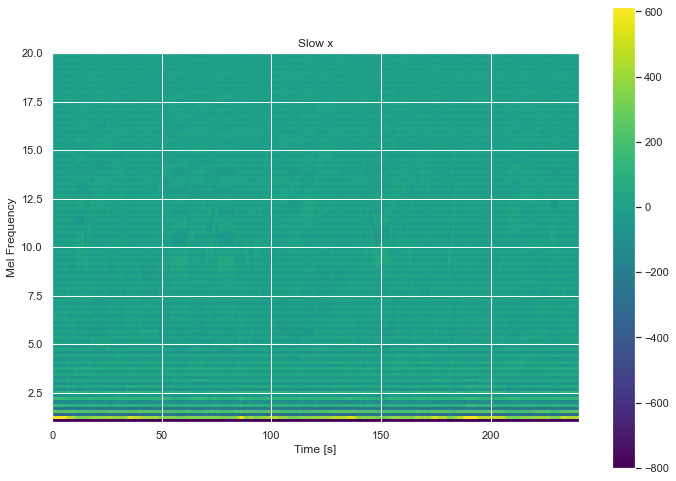

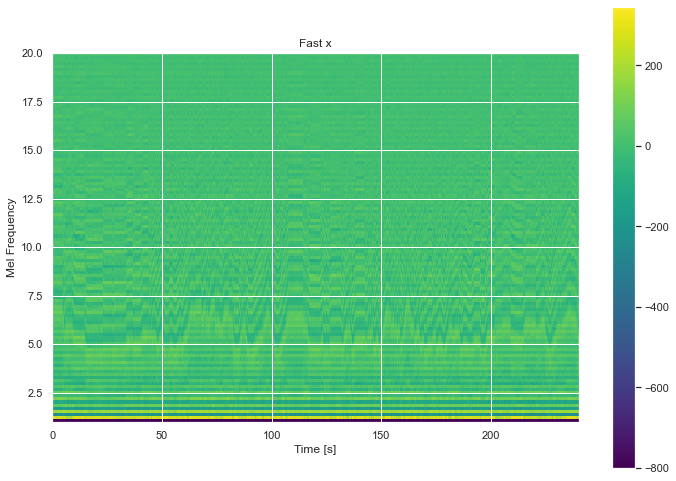

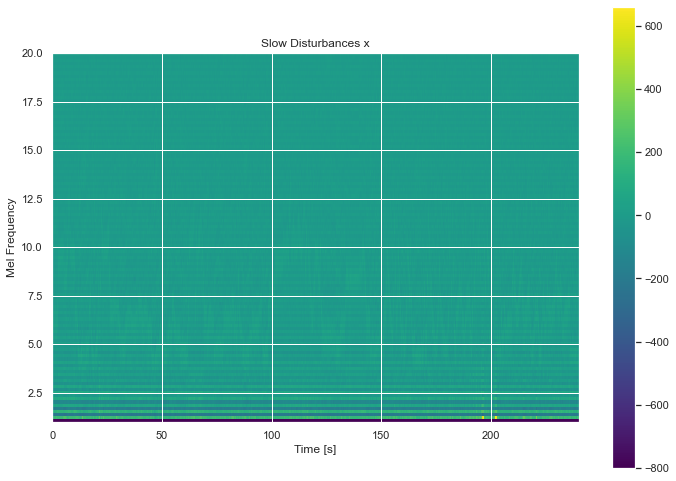

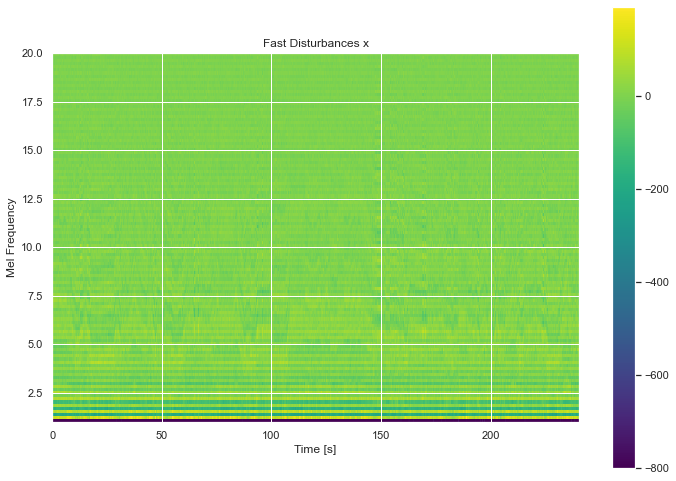

In [5]:
ax_S = show_specgram(mcc_spectrogram_matrix_S, 0.7, [0, len(signal_S)/Resampling_frequency, 20 ,1], cmin =-800, title='Slow '+Accelerometer_axis, y_axis = "Mel Frequency")
ax_F = show_specgram(mcc_spectrogram_matrix_F, 0.7, [0, len(signal_F)/Resampling_frequency, 20 ,1], cmin = -800, title='Fast '+Accelerometer_axis,  y_axis = "Mel Frequency")
ax_SD = show_specgram(mcc_spectrogram_matrix_SD, 0.7, [0, len(signal_SD)/Resampling_frequency, 20 ,1], cmin = -800, title='Slow Disturbances '+Accelerometer_axis,  y_axis = "Mel Frequency")
ax_FD = show_specgram(mcc_spectrogram_matrix_FD, 0.7, [0, len(signal_FD)/Resampling_frequency, 20 ,1], cmin = -800, title='Fast Disturbances '+Accelerometer_axis,  y_axis = "Mel Frequency")

<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Feature separability analysis

It is possible to use the MFCC features for signal classification purpose, in this example it is shown how the four classes can be separated using a dimensionality reduction  technique (Linear Discriminant Analysis) applied to the 128 Mel Frequency Cepstrum Coefficients.

<br>



### k-NN Accuracy Test

The classification has been tested using k-NN classification algorithm on the dataset when dimensionality reduction technique is applied and not applied

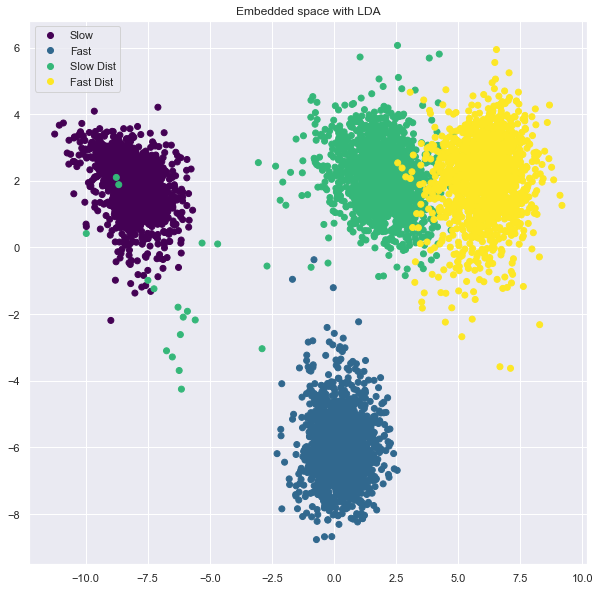

In [6]:
X_S = mcc_spectrogram_matrix_S.T
X_F = mcc_spectrogram_matrix_F.T
X_SD = mcc_spectrogram_matrix_SD.T
X_FD = mcc_spectrogram_matrix_FD.T

y_S = np.ones(len(X_S))*0
y_F = np.ones(len(X_F))*1
y_SD = np.ones(len(X_SD))*2
y_FD = np.ones(len(X_FD))*3

X = np.concatenate((X_S,X_F,X_SD,X_FD))
y = np.concatenate((y_S,y_F,y_SD,y_FD))

lda = LDA(n_components=2)
x_lda = lda.fit_transform(X, y)

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_lda[:,0], x_lda[:,1], c=y, cmap = 'viridis')

plt.legend(handles=scatter.legend_elements()[0], labels=['Slow','Fast','Slow Dist','Fast Dist'])
plt.title("Embedded space with LDA")
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

n_classes = len(np.unique(y))
n_neighbors = 5
lda = make_pipeline(StandardScaler(), LDA(n_components=3))
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

lda.fit(X_train, y_train)
knn.fit(lda.transform(X_train), y_train)
acc_knn = knn.score(lda.transform(X_test), y_test)
print('\nAccuracy with dimensionality reduction technique:   ', acc_knn, '\n')

knn.fit(X_train, y_train)
acc_knn = knn.score(X_test, y_test)
print('Accuracy without dimensionality reduction technique:   ', acc_knn)


Accuracy with dimensionality reduction technique:    0.9984017048481619 

Accuracy without dimensionality reduction technique:    0.9994672349493873
